# Training
* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv
import tensorflow_hub as hub

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Conv2D, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from shapely import wkt
from keras import backend as K 


from IAdeforestation.tools import *
from IAdeforestation.training import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Check if GPU device is available

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10816170759614858768
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9359531793429425741
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
IMAGES_DIR = 'images'
SAVED_MODELS_PATH = os.path.join("saved_models", "tensowflow_hub")

## Coffee vs Other

In [4]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1", tags=['train'], input_shape=(64,64,3))

### Create model

In [5]:
def create_model():
    model = Sequential()
    model.add(Input(2048))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

### Add earlystopper and tensorboard

In [12]:
RUN_NAME = '32x32'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

### Run model

In [13]:
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 3

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=70,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE),
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE),
                        callbacks=[earlystopper, tensorboard])

Train for 83 steps, validate for 41 steps
Epoch 1/70
83/83 [==============================] - 143s 2s/step - loss: 1.2686 - accuracy: 0.5399 - val_loss: 0.7868 - val_accuracy: 0.6513
Epoch 2/70
83/83 [==============================] - 94s 1s/step - loss: 1.0222 - accuracy: 0.5847 - val_loss: 0.7613 - val_accuracy: 0.6734
Epoch 3/70
83/83 [==============================] - 79s 958ms/step - loss: 0.9544 - accuracy: 0.6005 - val_loss: 0.7486 - val_accuracy: 0.6944
Epoch 4/70
83/83 [==============================] - 74s 888ms/step - loss: 0.9217 - accuracy: 0.6152 - val_loss: 0.7394 - val_accuracy: 0.6940
Epoch 5/70
83/83 [==============================] - 72s 867ms/step - loss: 0.8979 - accuracy: 0.6194 - val_loss: 0.7241 - val_accuracy: 0.7039
Epoch 6/70
83/83 [==============================] - 71s 856ms/step - loss: 0.8830 - accuracy: 0.6286 - val_loss: 0.7221 - val_accuracy: 0.7054
Epoch 7/70
83/83 [==============================] - 71s 851ms/step - loss: 0.8490 - accuracy: 0.6323 - va

Epoch 58/70
83/83 [==============================] - 70s 848ms/step - loss: 0.6795 - accuracy: 0.6822 - val_loss: 0.6492 - val_accuracy: 0.7416
Epoch 59/70
83/83 [==============================] - 71s 850ms/step - loss: 0.6821 - accuracy: 0.6999 - val_loss: 0.6394 - val_accuracy: 0.7355
Epoch 60/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6847 - accuracy: 0.6931 - val_loss: 0.6508 - val_accuracy: 0.7268
Epoch 61/70
83/83 [==============================] - 70s 845ms/step - loss: 0.6911 - accuracy: 0.6862 - val_loss: 0.6397 - val_accuracy: 0.7355
Epoch 62/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6824 - accuracy: 0.6860 - val_loss: 0.6430 - val_accuracy: 0.7420
Epoch 63/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6838 - accuracy: 0.6873 - val_loss: 0.6555 - val_accuracy: 0.7184
Epoch 64/70
83/83 [==============================] - 70s 848ms/step - loss: 0.6615 - accuracy: 0.7046 - val_loss: 0.6497 - val_accuracy:

### Save model

In [14]:
SAVED_MODELS_PATH = 'saved_models'
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

### Train and test accuracy/error

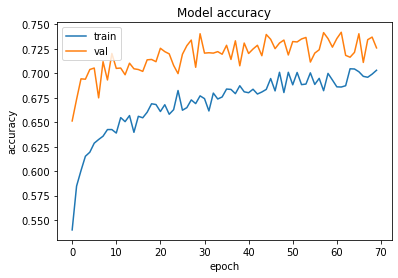

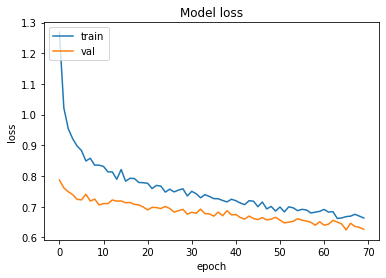

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate generator

In [16]:
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6493916531403859, 0.7135417]

### Compute confusion matrix and metrics

In [18]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(model.predict_classes(X))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [19]:
cm = confusion_matrix(Y_true, Y_pred)

In [20]:
cm

array([[729, 244],
       [275, 672]], dtype=int64)

In [21]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       973
           1       0.73      0.71      0.72       947

    accuracy                           0.73      1920
   macro avg       0.73      0.73      0.73      1920
weighted avg       0.73      0.73      0.73      1920

F1-Score : 0.7214170692431562


### Stratified cross-val

In [6]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [7]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [8]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'strat_coffee_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [9]:
fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = keras_layer_generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'][1:4], 
                                  eurosat_params['std'][1:4], 
                                hub_layer,
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = keras_layer_generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'][1:4], 
                                eurosat_params['std'][1:4],
                                hub_layer,
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1


Epoch 1/100
60/60 [==============================] - 9s 152ms/step - loss: 1.6134 - accuracy: 0.4768 - precision: 0.7976 - recall: 0.4277 - val_loss: 0.9282 - val_accuracy: 0.6583 - val_precision: 0.8367 - val_recall: 0.6796
Epoch 2/100
60/60 [==============================] - 8s 142ms/step - loss: 1.5731 - accuracy: 0.4994 - precision: 0.7884 - recall: 0.4778 - val_loss: 0.8751 - val_accuracy: 0.7146 - val_precision: 0.8748 - val_recall: 0.7355
Epoch 3/100
60/60 [==============================] - 8s 143ms/step - loss: 1.5013 - accuracy: 0.5334 - precision: 0.7865 - recall: 0.5294 - val_loss: 0.8685 - val_accuracy: 0.7073 - val_precision: 0.8470 - val_recall: 0.7448
Epoch 4/100
60/60 [==============================] - 9s 145ms/step - loss: 1.4096 - accuracy: 0.5527 - precision: 0.8165 - recall: 0.5352 - val_loss: 0.8159 - val_accuracy: 0.7417 - val_precision: 0.8758 - val_recall: 0.7737
Epoch 5/100
60/60 [==============================] - 8s 144ms/step - loss: 1.4299 - accuracy: 0.5609

60/60 [==============================] - 9s 147ms/step - loss: 0.8379 - accuracy: 0.7325 - precision: 0.9038 - recall: 0.7256 - val_loss: 0.7057 - val_accuracy: 0.7708 - val_precision: 0.9285 - val_recall: 0.7694
Epoch 74/100
60/60 [==============================] - 9s 147ms/step - loss: 0.9266 - accuracy: 0.7296 - precision: 0.8926 - recall: 0.7282 - val_loss: 0.6909 - val_accuracy: 0.7854 - val_precision: 0.9167 - val_recall: 0.7879
Epoch 75/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8203 - accuracy: 0.7419 - precision: 0.9172 - recall: 0.7279 - val_loss: 0.7065 - val_accuracy: 0.7927 - val_precision: 0.9357 - val_recall: 0.7854
Epoch 76/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8336 - accuracy: 0.7322 - precision: 0.9093 - recall: 0.7246 - val_loss: 0.6873 - val_accuracy: 0.7917 - val_precision: 0.9176 - val_recall: 0.7964
Epoch 77/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8374 - accuracy: 0.7376 - preci

60/60 [==============================] - 9s 147ms/step - loss: 0.8539 - accuracy: 0.7230 - precision: 0.8990 - recall: 0.7185 - val_loss: 0.7650 - val_accuracy: 0.7729 - val_precision: 0.9389 - val_recall: 0.7462
Epoch 45/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8527 - accuracy: 0.7322 - precision: 0.9034 - recall: 0.7207 - val_loss: 0.7732 - val_accuracy: 0.7729 - val_precision: 0.9253 - val_recall: 0.7528
Epoch 46/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8718 - accuracy: 0.7132 - precision: 0.8912 - recall: 0.7061 - val_loss: 0.7420 - val_accuracy: 0.7917 - val_precision: 0.9339 - val_recall: 0.7739
Epoch 47/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8457 - accuracy: 0.7390 - precision: 0.8976 - recall: 0.7371 - val_loss: 0.7410 - val_accuracy: 0.7885 - val_precision: 0.9480 - val_recall: 0.7597
Epoch 48/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8384 - accuracy: 0.7425 - preci

60/60 [==============================] - 9s 147ms/step - loss: 1.0470 - accuracy: 0.6502 - precision: 0.8587 - recall: 0.6446 - val_loss: 0.8704 - val_accuracy: 0.6979 - val_precision: 0.9295 - val_recall: 0.6516
Epoch 16/100
60/60 [==============================] - 9s 148ms/step - loss: 1.0558 - accuracy: 0.6409 - precision: 0.8527 - recall: 0.6391 - val_loss: 0.8536 - val_accuracy: 0.6833 - val_precision: 0.9114 - val_recall: 0.6413
Epoch 17/100
60/60 [==============================] - 9s 147ms/step - loss: 1.0126 - accuracy: 0.6647 - precision: 0.8613 - recall: 0.6574 - val_loss: 0.8365 - val_accuracy: 0.6896 - val_precision: 0.9231 - val_recall: 0.6504
Epoch 18/100
60/60 [==============================] - 9s 148ms/step - loss: 1.0181 - accuracy: 0.6607 - precision: 0.8609 - recall: 0.6532 - val_loss: 0.8219 - val_accuracy: 0.7115 - val_precision: 0.9457 - val_recall: 0.6621
Epoch 19/100
60/60 [==============================] - 9s 147ms/step - loss: 1.0579 - accuracy: 0.6784 - preci

60/60 [==============================] - 9s 147ms/step - loss: 0.8316 - accuracy: 0.7417 - precision: 0.8999 - recall: 0.7433 - val_loss: 0.7374 - val_accuracy: 0.7583 - val_precision: 0.9503 - val_recall: 0.7240
Epoch 88/100
60/60 [==============================] - 9s 147ms/step - loss: 0.7768 - accuracy: 0.7651 - precision: 0.9228 - recall: 0.7609 - val_loss: 0.7275 - val_accuracy: 0.7729 - val_precision: 0.9501 - val_recall: 0.7372
Epoch 89/100
60/60 [==============================] - 9s 148ms/step - loss: 0.8216 - accuracy: 0.7443 - precision: 0.8997 - recall: 0.7444 - val_loss: 0.7167 - val_accuracy: 0.7646 - val_precision: 0.9320 - val_recall: 0.7348
Epoch 90/100
60/60 [==============================] - 9s 147ms/step - loss: 0.7750 - accuracy: 0.7522 - precision: 0.9189 - recall: 0.7405 - val_loss: 0.7125 - val_accuracy: 0.7719 - val_precision: 0.9398 - val_recall: 0.7416
Epoch 91/100
60/60 [==============================] - 9s 147ms/step - loss: 0.7873 - accuracy: 0.7536 - preci

60/60 [==============================] - 9s 147ms/step - loss: 0.8490 - accuracy: 0.7293 - precision: 0.9067 - recall: 0.7159 - val_loss: 0.7326 - val_accuracy: 0.7875 - val_precision: 0.9099 - val_recall: 0.8005
Epoch 59/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8733 - accuracy: 0.7207 - precision: 0.8932 - recall: 0.7197 - val_loss: 0.7263 - val_accuracy: 0.7854 - val_precision: 0.9260 - val_recall: 0.7826
Epoch 60/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8420 - accuracy: 0.7406 - precision: 0.9100 - recall: 0.7296 - val_loss: 0.7213 - val_accuracy: 0.7792 - val_precision: 0.9262 - val_recall: 0.7766
Epoch 61/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8531 - accuracy: 0.7322 - precision: 0.8973 - recall: 0.7313 - val_loss: 0.7194 - val_accuracy: 0.7990 - val_precision: 0.9121 - val_recall: 0.8054
Epoch 62/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8250 - accuracy: 0.7385 - preci

60/60 [==============================] - 9s 147ms/step - loss: 0.9562 - accuracy: 0.6825 - precision: 0.8689 - recall: 0.6884 - val_loss: 0.7930 - val_accuracy: 0.7510 - val_precision: 0.9451 - val_recall: 0.7197
Epoch 30/100
60/60 [==============================] - 9s 147ms/step - loss: 0.9034 - accuracy: 0.7089 - precision: 0.8909 - recall: 0.7058 - val_loss: 0.7669 - val_accuracy: 0.7656 - val_precision: 0.9354 - val_recall: 0.7403
Epoch 31/100
60/60 [==============================] - 9s 147ms/step - loss: 0.8933 - accuracy: 0.7185 - precision: 0.8788 - recall: 0.7221 - val_loss: 0.8030 - val_accuracy: 0.7542 - val_precision: 0.9228 - val_recall: 0.7380
Epoch 32/100
60/60 [==============================] - 9s 148ms/step - loss: 0.8831 - accuracy: 0.7222 - precision: 0.8832 - recall: 0.7240 - val_loss: 0.8058 - val_accuracy: 0.7365 - val_precision: 0.9216 - val_recall: 0.7121
Epoch 33/100
60/60 [==============================] - 9s 147ms/step - loss: 0.9096 - accuracy: 0.7056 - preci

4/4 [==============================] - 0s 115ms/step - loss: 0.7340 - accuracy: 0.7461 - precision: 0.9456 - recall: 0.7092
Fold 4 loss : 0.7339873909950256
Fold 4 accuracy : 0.74609375
Fold 4 F1-score : 0.8104956344682339




In [10]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.7921875
Stdev accuracy : 0.03651037951733725


Mean loss : 0.6971019864082336
Stdev loss : 0.03521233766999082


Mean precision : 0.9544088244438171
Stdev precision : 0.013270416335635287


Mean recall : 0.7651004672050477
Stdev recall : 0.04877719196420569


Mean F1-Score : 0.848373879577232
Stdev F1-Score : 0.03009120641629622


In [11]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

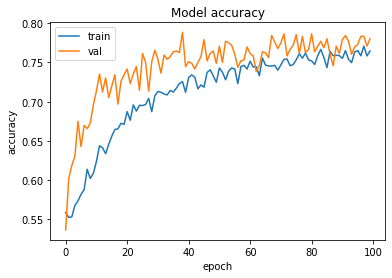

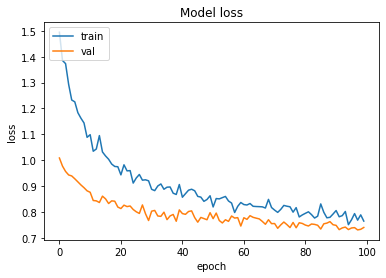

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
restored_model = load_model(os.path.join("saved_models/tensowflow_hub/Coffee/strat_coffee_2/strat_coffee_2_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})

In [14]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

1/1 [==============================] - 0s 187ms/step - loss: 0.7401 - accuracy: 0.7724 - precision: 0.9363 - recall: 0.7508
              precision    recall  f1-score   support

           0       0.51      0.84      0.63       100
           1       0.94      0.74      0.83       313

    accuracy                           0.76       413
   macro avg       0.72      0.79      0.73       413
weighted avg       0.83      0.76      0.78       413

F1-Score : 0.8250000000000001


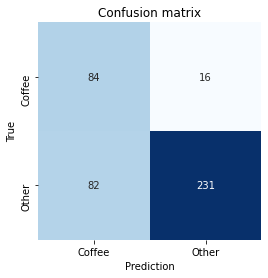

In [15]:
test_generator = keras_layer_generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'][1:4], 
                            eurosat_params['std'][1:4], 
                           hub_layer,
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs No culture
### Split culture and no culture class

In [7]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

### Histogramm of class repartition

Text(0.5, 1.0, 'Number of images by classes')

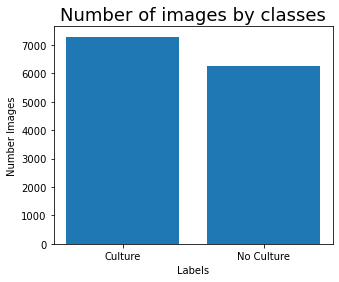

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(['Culture', 'No Culture'], [nb_culture, nb_no_culture])
ax.set_xlabel('Labels')
ax.set_ylabel('Number Images')
ax.set_title('Number of images by classes', fontsize=18)

### Get images path on disk

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_no_culture = [1]*len(path_no_culture)



### Split train/test and create generator

In [10]:
BATCH_SIZE = 64

file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25)
train_generator = keras_layer_generator(path_train, y_train, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)

### Create model

In [11]:
model_culture = Sequential()
model_culture.add(Input(2048))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(1, activation='sigmoid'))

model_culture.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 266,433
Trainable params: 266,433
Non-trainable params: 0
__________________________________________________

### Add earlystopper and tensorboard

In [12]:
RUN_NAME = '32x32culture'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

### Train model

In [13]:
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 3

model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=100,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 474 steps, validate for 156 steps
Epoch 1/100
474/474 [==============================] - 795s 2s/step - loss: 1.0842 - accuracy: 0.5863 - val_loss: 0.8801 - val_accuracy: 0.7191
Epoch 2/100
474/474 [==============================] - 401s 847ms/step - loss: 0.9309 - accuracy: 0.6511 - val_loss: 0.8437 - val_accuracy: 0.7342
Epoch 3/100
474/474 [==============================] - 407s 859ms/step - loss: 0.8737 - accuracy: 0.6836 - val_loss: 0.8197 - val_accuracy: 0.7416
Epoch 4/100
474/474 [==============================] - 394s 830ms/step - loss: 0.8502 - accuracy: 0.6935 - val_loss: 0.8110 - val_accuracy: 0.7289
Epoch 5/100
474/474 [==============================] - 372s 786ms/step - loss: 0.8310 - accuracy: 0.7029 - val_loss: 0.7995 - val_accuracy: 0.7278
Epoch 6/100
474/474 [==============================] - 363s 765ms/step - loss: 0.8086 - accuracy: 0.7088 - val_loss: 0.7757 - val_accuracy: 0.7355
Epoch 7/100
474/474 [==============================] - 386s 815ms/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



474/474 [==============================] - 361s 762ms/step - loss: 0.6310 - accuracy: 0.7460 - val_loss: 0.6048 - val_accuracy: 0.7612
Epoch 19/100
474/474 [==============================] - 361s 761ms/step - loss: 0.6268 - accuracy: 0.7460 - val_loss: 0.6006 - val_accuracy: 0.7584
Epoch 20/100
474/474 [==============================] - 360s 761ms/step - loss: 0.6163 - accuracy: 0.7513 - val_loss: 0.5966 - val_accuracy: 0.7604
Epoch 21/100
474/474 [==============================] - 360s 759ms/step - loss: 0.6126 - accuracy: 0.7457 - val_loss: 0.5904 - val_accuracy: 0.7618
Epoch 22/100
474/474 [==============================] - 360s 759ms/step - loss: 0.6028 - accuracy: 0.7500 - val_loss: 0.5784 - val_accuracy: 0.7670
Epoch 23/100
474/474 [==============================] - 360s 760ms/step - loss: 0.5957 - accuracy: 0.7509 - val_loss: 0.5804 - val_accuracy: 0.7564
Epoch 24/100
474/474 [==============================] - 360s 760ms/step - loss: 0.5869 - accuracy: 0.7541 - val_loss: 0.5718 

### Save model

In [14]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

### Train and test accuracy/error

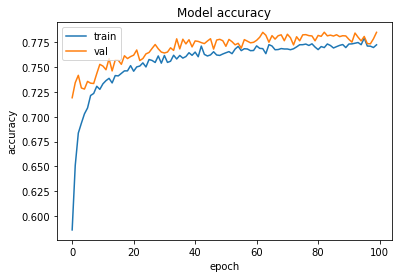

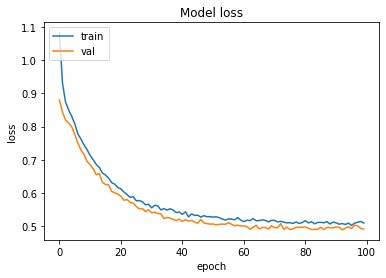

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate model

In [16]:
model_culture.evaluate_generator(test_generator,30)

[0.49332220753033956, 0.77552086]

### Compute confusion matrix and metrics

In [18]:
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer,batch_size=BATCH_SIZE)

Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(model_culture.predict_classes(X))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [19]:
cm = confusion_matrix(Y_true, Y_pred)
cm

array([[885, 121],
       [296, 618]], dtype=int64)

In [20]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1006
           1       0.84      0.68      0.75       914

    accuracy                           0.78      1920
   macro avg       0.79      0.78      0.78      1920
weighted avg       0.79      0.78      0.78      1920

F1-Score : 0.7477313974591652


## Stratified Cross val

In [7]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_train_culture_32.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [8]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_32_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [9]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = keras_layer_generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'][1:4], 
                                  eurosat_params['std'][1:4], 
                                hub_layer,
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = keras_layer_generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'][1:4], 
                                eurosat_params['std'][1:4],
                                hub_layer,
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
70/70 [==============================] - 10s 132ms/step - loss: 1.5851 - accuracy: 0.5301 - precision: 0.4794 - recall: 0.4710 - val_loss: 0.8291 - val_accuracy: 0.7656 - val_precision: 0.7370 - val_recall: 0.7068
Epoch 2/100
70/70 [==============================] - 9s 126ms/step - loss: 1.2151 - accuracy: 0.6338 - precision: 0.5850 - recall: 0.5905 - val_loss: 0.7662 - val_accuracy: 0.7979 - val_precision: 0.7654 - val_recall: 0.7494acy: 0.6286 - precision: 0.57
Epoch 3/100
70/70 [==============================] - 9s 127ms/step - loss: 1.1077 - accuracy: 0.6694 - precision: 0.6397 - recall: 0.6165 - val_loss: 0.7587 - val_accuracy: 0.7998 - val_precision: 0.8017 - val_recall: 0.7705
Epoch 4/100
70/70 [==============================] - 9s 127ms/step - loss: 1.0272 - accuracy: 0.7063 - precision: 0.6578 - recall: 0.7005 - val_loss: 0.7272 - val_accuracy: 0.8145 - val_precision: 0.7991 - val_recall: 0.7668
Epoch 5/100
70/70 [==============================] - 9s 128ms/step - l

70/70 [==============================] - 9s 129ms/step - loss: 0.5970 - accuracy: 0.8301 - precision: 0.8188 - recall: 0.7922 - val_loss: 0.5588 - val_accuracy: 0.8613 - val_precision: 0.8716 - val_recall: 0.7968
Epoch 74/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6308 - accuracy: 0.8066 - precision: 0.7875 - recall: 0.7690 - val_loss: 0.5613 - val_accuracy: 0.8408 - val_precision: 0.8741 - val_recall: 0.7543
Epoch 75/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6134 - accuracy: 0.8140 - precision: 0.8213 - recall: 0.7498 - val_loss: 0.5632 - val_accuracy: 0.8418 - val_precision: 0.8635 - val_recall: 0.7648
Epoch 76/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6059 - accuracy: 0.8230 - precision: 0.8318 - recall: 0.7678 - val_loss: 0.5443 - val_accuracy: 0.8516 - val_precision: 0.8879 - val_recall: 0.7902
Epoch 77/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6139 - accuracy: 0.8221 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.6706 - accuracy: 0.8118 - precision: 0.8077 - recall: 0.7628 - val_loss: 0.6143 - val_accuracy: 0.8545 - val_precision: 0.9310 - val_recall: 0.7405
Epoch 45/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6825 - accuracy: 0.8099 - precision: 0.8071 - recall: 0.7505 - val_loss: 0.6045 - val_accuracy: 0.8330 - val_precision: 0.9128 - val_recall: 0.7068
Epoch 46/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6767 - accuracy: 0.8038 - precision: 0.8012 - recall: 0.7563 - val_loss: 0.6029 - val_accuracy: 0.8369 - val_precision: 0.8862 - val_recall: 0.7298
Epoch 47/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6771 - accuracy: 0.8133 - precision: 0.8302 - recall: 0.7501 - val_loss: 0.5919 - val_accuracy: 0.8506 - val_precision: 0.8776 - val_recall: 0.7607
Epoch 48/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6535 - accuracy: 0.8261 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.6691 - accuracy: 0.8181 - precision: 0.8155 - recall: 0.7706 - val_loss: 0.6192 - val_accuracy: 0.8271 - val_precision: 0.8555 - val_recall: 0.7703
Epoch 45/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6479 - accuracy: 0.8203 - precision: 0.8077 - recall: 0.7755 - val_loss: 0.6137 - val_accuracy: 0.8340 - val_precision: 0.8231 - val_recall: 0.7860
Epoch 46/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6399 - accuracy: 0.8277 - precision: 0.8323 - recall: 0.7808 - val_loss: 0.5812 - val_accuracy: 0.8418 - val_precision: 0.8538 - val_recall: 0.7880
Epoch 47/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6408 - accuracy: 0.8234 - precision: 0.8256 - recall: 0.7663 - val_loss: 0.6078 - val_accuracy: 0.8193 - val_precision: 0.8278 - val_recall: 0.7780
Epoch 48/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6505 - accuracy: 0.8239 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.7814 - accuracy: 0.7830 - precision: 0.7647 - recall: 0.7420 - val_loss: 0.7198 - val_accuracy: 0.7988 - val_precision: 0.8470 - val_recall: 0.6739
Epoch 16/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7647 - accuracy: 0.7875 - precision: 0.7853 - recall: 0.7430 - val_loss: 0.6985 - val_accuracy: 0.8154 - val_precision: 0.8535 - val_recall: 0.7155
Epoch 17/100
70/70 [==============================] - 9s 130ms/step - loss: 0.7518 - accuracy: 0.7971 - precision: 0.7802 - recall: 0.7545 - val_loss: 0.7147 - val_accuracy: 0.8096 - val_precision: 0.8787 - val_recall: 0.6849
Epoch 18/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7796 - accuracy: 0.7797 - precision: 0.7556 - recall: 0.7508 - val_loss: 0.7082 - val_accuracy: 0.8105 - val_precision: 0.8800 - val_recall: 0.7068
Epoch 19/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7458 - accuracy: 0.7959 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.5585 - accuracy: 0.8335 - precision: 0.8600 - recall: 0.7663 - val_loss: 0.5611 - val_accuracy: 0.8213 - val_precision: 0.8690 - val_recall: 0.7248
Epoch 88/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5501 - accuracy: 0.8434 - precision: 0.8341 - recall: 0.8026 - val_loss: 0.5403 - val_accuracy: 0.8486 - val_precision: 0.9305 - val_recall: 0.7296
Epoch 89/100
70/70 [==============================] - 9s 130ms/step - loss: 0.5689 - accuracy: 0.8328 - precision: 0.8527 - recall: 0.7700 - val_loss: 0.5529 - val_accuracy: 0.8447 - val_precision: 0.9019 - val_recall: 0.7291
Epoch 90/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5400 - accuracy: 0.8436 - precision: 0.8638 - recall: 0.7727 - val_loss: 0.5703 - val_accuracy: 0.8174 - val_precision: 0.8436 - val_recall: 0.7231
Epoch 91/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5581 - accuracy: 0.8226 - preci

In [10]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8421875
Stdev accuracy : 0.028874560332150512


Mean loss : 0.5812037765979767
Stdev loss : 0.09212604479674416


Mean precision : 0.8728580355644227
Stdev precision : 0.03476147047396918


Mean recall : 0.764775276184082
Stdev recall : 0.0583547704819978


Mean F1-Score : 0.8140180476198997
Stdev F1-Score : 0.03828002179382775


In [11]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [12]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_test_culture_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

In [13]:
restored_model = load_model(os.path.join("saved_models/tensowflow_hub/Culture/strat_culture_32_1/strat_culture_32_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 0s 190ms/step - loss: 0.5858 - accuracy: 0.8534 - precision: 0.8996 - recall: 0.7563
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       396
           1       0.90      0.75      0.82       320

    accuracy                           0.85       716
   macro avg       0.86      0.84      0.85       716
weighted avg       0.86      0.85      0.85       716

F1-Score : 0.8191126279863481


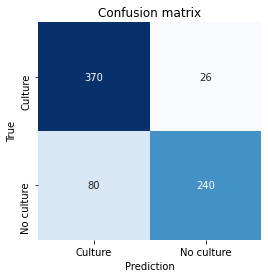

In [14]:
test_generator = keras_layer_generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'][1:4], 
                            eurosat_params['std'][1:4], 
                           hub_layer,
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")